# 任务二 —— 共享单车使用量预测
## 任务一 —— 使用线性预测
+ 加载相关库

In [1]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt

d:\anaconda3\envs\Tpytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


+ 从kaggle上下载数据集，并得到温度(temp)和日租量(cnt)的相关数据，并将它们转化为形状为(数据量，1)的张量。

In [2]:
# 从kaggle中下载数据集
dataset_path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")

# 加载数据集
orignal_data_day = pd.read_csv(os.path.join(dataset_path,'day.csv'))

#得到输入temp和输出cnt
#这里的inputs，outputs对应X_df, Y_df
inputs, outputs = orignal_data_day['temp'], orignal_data_day['cnt']

#转化为张量
#这里的X,Y对应X_tensor, Y_tensor
X, Y = torch.tensor(inputs.values,dtype=torch.float32), torch.tensor(outputs.values,dtype=torch.float32)
X, Y = X.reshape(-1,1), Y.reshape(-1,1)

+ 使用现有api定义简单的线性模型，初始化方法。

In [3]:
#定义线性回归神经网络
class LinearRegressionModel(nn.Module):
    def __init__(self, in_features:int, out_features:int,bias = True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias = bias)

    def forward(self,x):
        return self.linear(x)

#定义初始化方法
def init_params(m):
    if type(m) == nn.Module:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.fill_(0.)


#定义损失函数
criterion = nn.MSELoss(reduction='mean')

+ 初始化模型，设置超参数，加载数据集并开始训练。在训练后，对训练数据进行预测产生最终的拟合直线

In [4]:
#创建网络并初始化
net = LinearRegressionModel(1,1)
net.apply(init_params)
#加载数据集并设置超参数
lr = 0.5
epoch_nums = 100
batch_size = 32
dataset = TensorDataset(X,Y)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)
#选择随机梯度下降作为优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss_data = []# 由于存储损失值
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 10 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 用训练好的模型进行预测得到最终的拟合直线
with torch.no_grad():
    y_pred = net(X)

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:10 Loss: 2420653.8098
Epoch:20 Loss: 2342186.6576
Epoch:30 Loss: 2374972.9185
Epoch:40 Loss: 2424619.3207
Epoch:50 Loss: 2427043.4348
Epoch:60 Loss: 2468745.8587
Epoch:70 Loss: 2483746.3315
Epoch:80 Loss: 2430979.9674
Epoch:90 Loss: 2415918.4293
Epoch:100 Loss: 2396770.2989
训练后的参数:
OrderedDict([('linear.weight', tensor([[6567.6104]])), ('linear.bias', tensor([1100.4435]))])


+ 画出相关图像

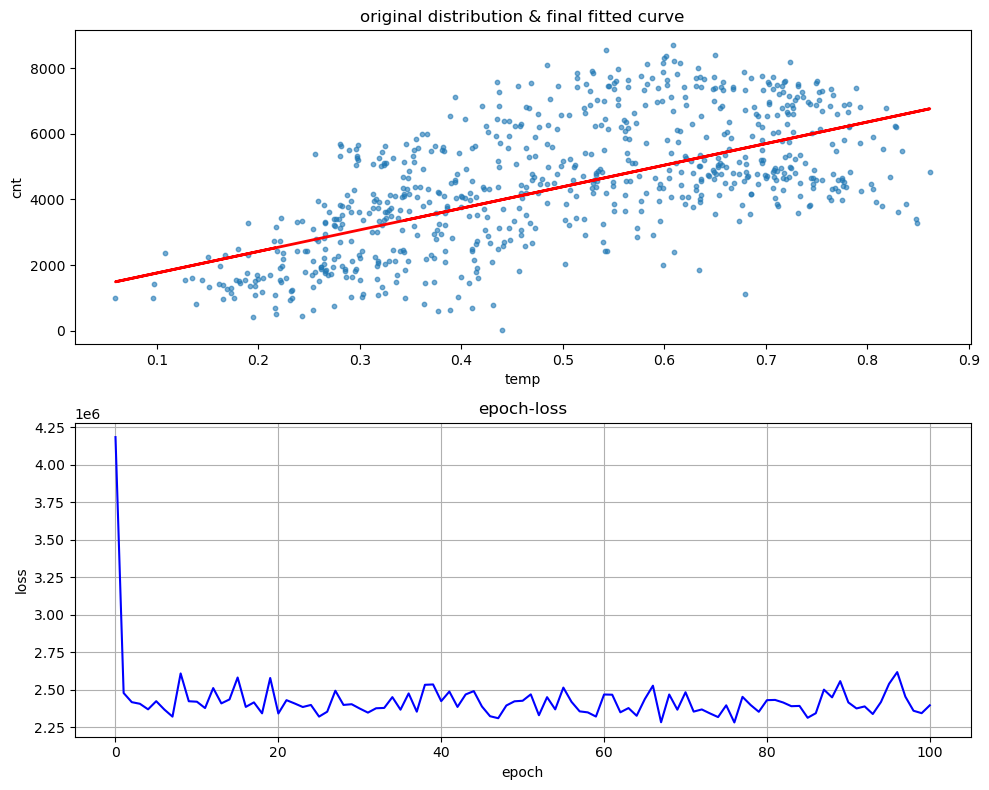

In [5]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

***
## 任务二 —— 拟合非线性关系
+ 定义一个含隐藏层和非线性激活函数的简单神经网络。其中，隐藏层输出等于10，非线性激活函数采用sigmoid()

In [6]:
class NonLinearModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_features = 10, bias = True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_features, out_features, bias=bias)

    def forward(self,x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        return x

+ 替换之前采用的网络并进行训练。

In [7]:
#创建网络并初始化
net = NonLinearModel(1,1,hidden_features=10)
net.apply(init_params)

#加载数据集并设置超参数
lr = 0.1
epoch_nums = 1000
loss_data = []# 由于存储损失值
dataset = TensorDataset(X,Y)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)
#选择随机梯度下降作为优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 100 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:100 Loss: 3784867.2283
Epoch:200 Loss: 3802502.2500
Epoch:300 Loss: 3864533.4457
Epoch:400 Loss: 3791680.4891
Epoch:500 Loss: 3781182.2174
Epoch:600 Loss: 3827808.0217
Epoch:700 Loss: 3850172.5978
Epoch:800 Loss: 3821456.3370
Epoch:900 Loss: 3785773.2011
Epoch:1000 Loss: 3790318.8043
训练后的参数:
OrderedDict([('linear1.weight', tensor([[ -22.3539],
        [ -19.5731],
        [  23.2521],
        [ -13.4691],
        [ -20.8429],
        [ -22.4603],
        [ -17.6238],
        [ -12.2323],
        [  31.4548],
        [7967.0801]])), ('linear1.bias', tensor([ -46.9948,  -42.0555,   49.2117,  -29.6629,  -42.6655,  -47.8665,
         -38.6927,  -26.7032,   62.5726, 8265.5928])), ('linear2.weight', tensor([[ 605.3665,  343.9865,  832.3929,  634.1836,  349.5643,  568.8658,
          396.1633,  257.7654,  915.7970, 1010.5028]])), ('linear2.bias', tensor([1357.5426]))])


+ 将X按温度升序排列后得到拟合曲线

In [8]:
X_sorted, indices = torch.sort(X, dim=0)
with torch.no_grad():
    y_pred = net(X_sorted)

+ 绘图（这是最初训练的结果，**下面有改进**）

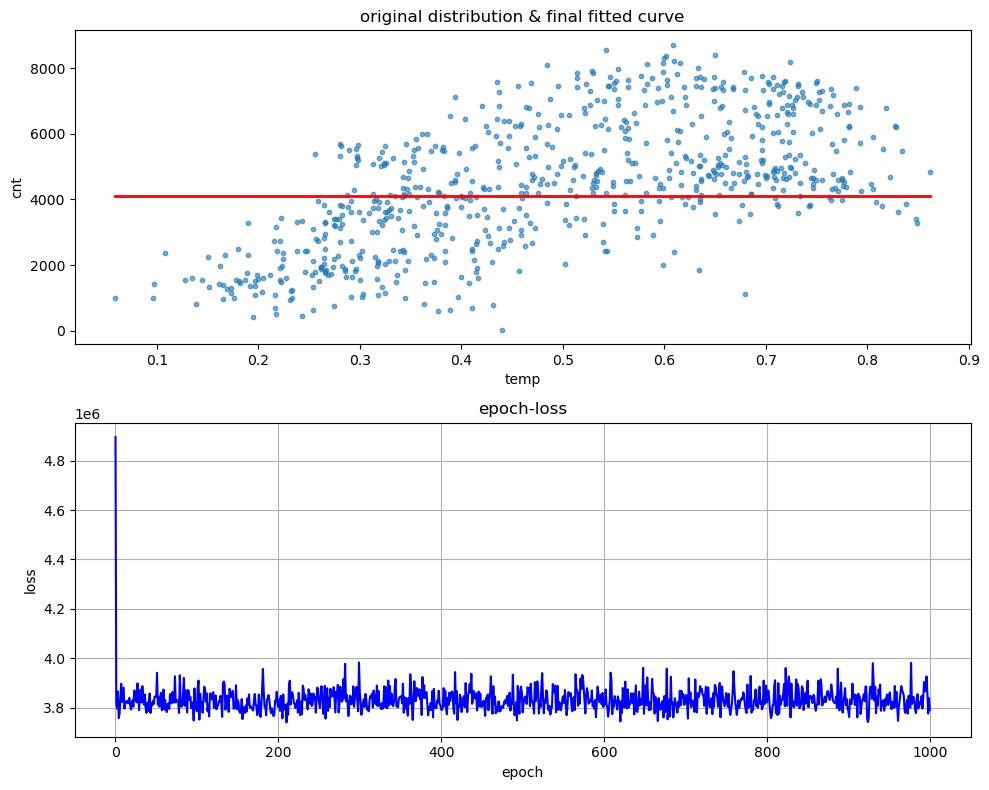

In [9]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X_sorted.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

+ **训练结果分析**：可以看到，虽然模型的表达能力增强了，训练轮数增加了，但训练效果却远远没有线性模型好。一开始我很纳闷，当我看了一下训练数据后，我想明白了。原数据是通过多个特征预测一个输出，而这里的输入特征只有``temp``。而且``temp``的值很小却要生成``cnt``那么大的值会需要很大的参数值。当参数值过大时，学习率的设计又会变得很困难了。为此，我们需对数据进行标准化并采用对超参数不那么敏感的Adam优化器。

In [10]:
# 数据标准化
X_mean, X_std = X.mean(), X.std()
X_normalized = (X - X_mean) / X_std

Y_mean, Y_std = Y.mean(), Y.std()
Y_normalized = (Y - Y_mean) / Y_std

#重载数据集并设置超参数
dataset = TensorDataset(X_normalized,Y_normalized)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)

In [11]:
#创建网络并初始化
net = NonLinearModel(1,1,hidden_features=10)
net.apply(init_params)

#加载数据集并设置超参数
lr = 0.001
epoch_nums = 1000
loss_data = []# 由于存储损失值
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 100 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:100 Loss: 0.5688
Epoch:200 Loss: 0.5521
Epoch:300 Loss: 0.5446
Epoch:400 Loss: 0.5442
Epoch:500 Loss: 0.5442
Epoch:600 Loss: 0.5424
Epoch:700 Loss: 0.5430
Epoch:800 Loss: 0.5440
Epoch:900 Loss: 0.5435
Epoch:1000 Loss: 0.5416
训练后的参数:
OrderedDict([('linear1.weight', tensor([[-0.7695],
        [-1.6915],
        [-0.6333],
        [-0.6081],
        [-0.6108],
        [-1.5772],
        [-1.7769],
        [-1.7283],
        [ 1.7505],
        [-1.0832]])), ('linear1.bias', tensor([ 0.0811, -1.2676, -0.2900, -0.3189,  0.1031, -0.7037, -1.2713, -1.7555,
         1.2588,  0.7815])), ('linear2.weight', tensor([[ 0.2301, -0.5797,  0.2595,  0.3116,  0.0742, -0.1709, -0.9083, -1.1633,
          0.4518,  0.3255]])), ('linear2.bias', tensor([-0.1061]))])


+ 输出时反标准化输出

In [12]:
X_normalized_sorted, indices = torch.sort(X_normalized, dim=0)
# 预测时也要标准化输入，然后反标准化输出
with torch.no_grad():
    net.eval()
    y_pred_normalized = net(X_normalized_sorted)
    y_pred = y_pred_normalized * Y_std + Y_mean  # 反标准化

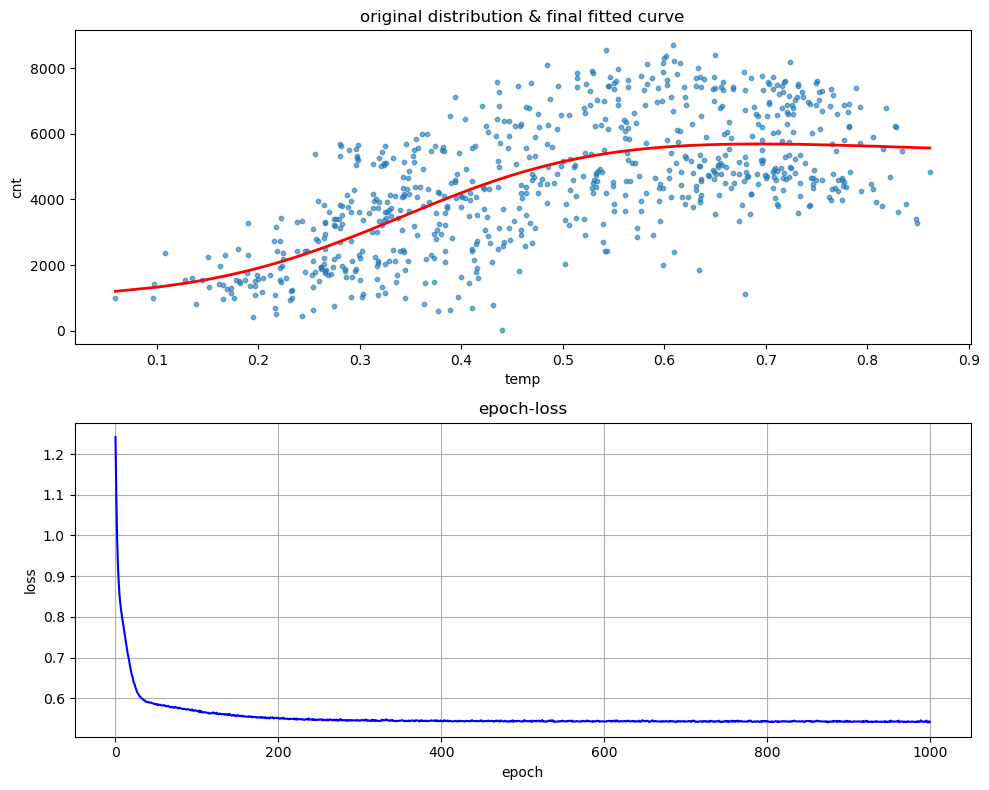

In [13]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X_sorted.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

+ 经过上述调整后，得到了一条优美的曲线。经过我的测试，在训练轮数为1000轮时，学习率lr = 0.001最佳。若高于这个值，损失函数的震荡会比较明显；低于这个值，损失函数值会较高。

***
## 思考题
+ 定义一个只含有线性层和激活函数ReLU的模型

In [49]:
class LinearReLUModel(nn.Module):
    def __init__(self, in_features, out_features, bias = True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias = bias)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        return x

In [65]:
# 数据标准化
X_mean, X_std = X.mean(), X.std()
X_normalized = (X - X_mean) / X_std

Y_mean, Y_std = Y.mean(), Y.std()
Y_normalized = (Y - Y_mean) / Y_std

#重载数据集并设置超参数
dataset = TensorDataset(X_normalized,Y_normalized)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)

In [66]:
#创建网络并初始化
net = LinearReLUModel(1,1)
net.apply(init_params)

#加载数据集并设置超参数
lr = 0.001
epoch_nums = 1000
loss_data = []# 由于存储损失值
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 100 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:100 Loss: 0.8483
Epoch:200 Loss: 0.8482
Epoch:300 Loss: 0.8487
Epoch:400 Loss: 0.8487
Epoch:500 Loss: 0.8478
Epoch:600 Loss: 0.8482
Epoch:700 Loss: 0.8491
Epoch:800 Loss: 0.8468
Epoch:900 Loss: 0.8485
Epoch:1000 Loss: 0.8492
训练后的参数:
OrderedDict([('linear.weight', tensor([[0.3482]])), ('linear.bias', tensor([0.2105]))])


In [67]:
X_normalized_sorted, indices = torch.sort(X_normalized, dim=0)
# 预测时也要标准化输入，然后反标准化输出
with torch.no_grad():
    net.eval()
    y_pred_normalized = net(X_normalized_sorted)
    y_pred = y_pred_normalized * Y_std + Y_mean  # 反标准化

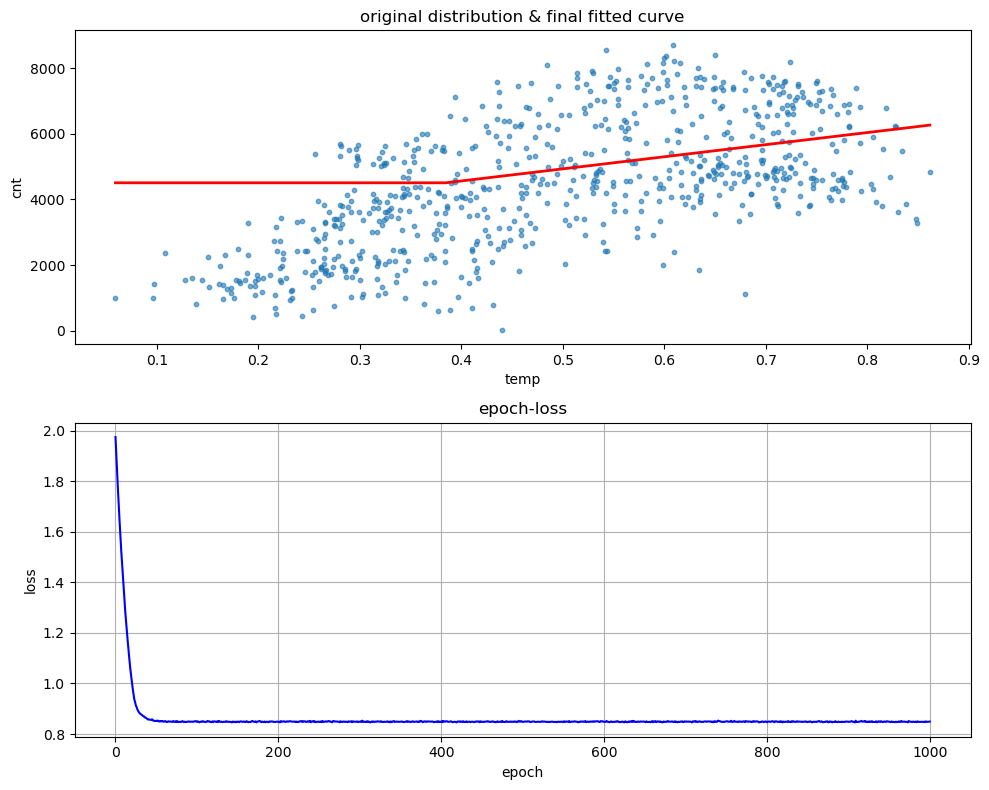

In [68]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X_sorted.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

+ **结果分析**：此次训练和任务二采用了一样的参数。可以看到最后的拟合曲线是一个折线。这是因为在单层线性层后接 ReLU 的网络，本质上只能表示一个分段线性函数：当线性输出落在负区间时，ReLU 会把它直接压成 0。我们可以尝试其它ReLU的变种改进模型对标准化后落在负区间的数据的处理，但这不能从根本上改变问题。要避免这种情况，我们应该增加网络层数，使ReLU在多层之间的使用过后让模型拥有非线性拟合能力。下面尝试ReLU的一个变种LeakyReLU进行改进，可以看到与原结果变化不大。

+ 使用LeakyReLU

In [57]:
class LinearLeakyReLUModel(nn.Module):
    def __init__(self, in_features, out_features, bias=True, negative_slope=0.7):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.activation = nn.LeakyReLU(negative_slope=negative_slope)

        # He 初始化（适用于 ReLU 系列激活）
        nn.init.kaiming_normal_(self.linear.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

In [58]:
# 数据标准化
X_mean, X_std = X.mean(), X.std()
X_normalized = (X - X_mean) / X_std

Y_mean, Y_std = Y.mean(), Y.std()
Y_normalized = (Y - Y_mean) / Y_std

#重载数据集并设置超参数
dataset = TensorDataset(X_normalized,Y_normalized)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)
net2 = LinearLeakyReLUModel(1,1)
#加载数据集并设置超参数
lr = 0.001
epoch_nums = 1000
loss_data = []# 由于存储损失值
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 100 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:100 Loss: 0.8491
Epoch:200 Loss: 0.8490
Epoch:300 Loss: 0.8484
Epoch:400 Loss: 0.8483
Epoch:500 Loss: 0.8485
Epoch:600 Loss: 0.8481
Epoch:700 Loss: 0.8469
Epoch:800 Loss: 0.8491
Epoch:900 Loss: 0.8499
Epoch:1000 Loss: 0.8498
训练后的参数:
OrderedDict([('linear.weight', tensor([[0.3497]])), ('linear.bias', tensor([0.2114]))])


In [59]:
X_normalized_sorted, indices = torch.sort(X_normalized, dim=0)
# 预测时也要标准化输入，然后反标准化输出
with torch.no_grad():
    net.eval()
    y_pred_normalized = net(X_normalized_sorted)
    y_pred = y_pred_normalized * Y_std + Y_mean  # 反标准化

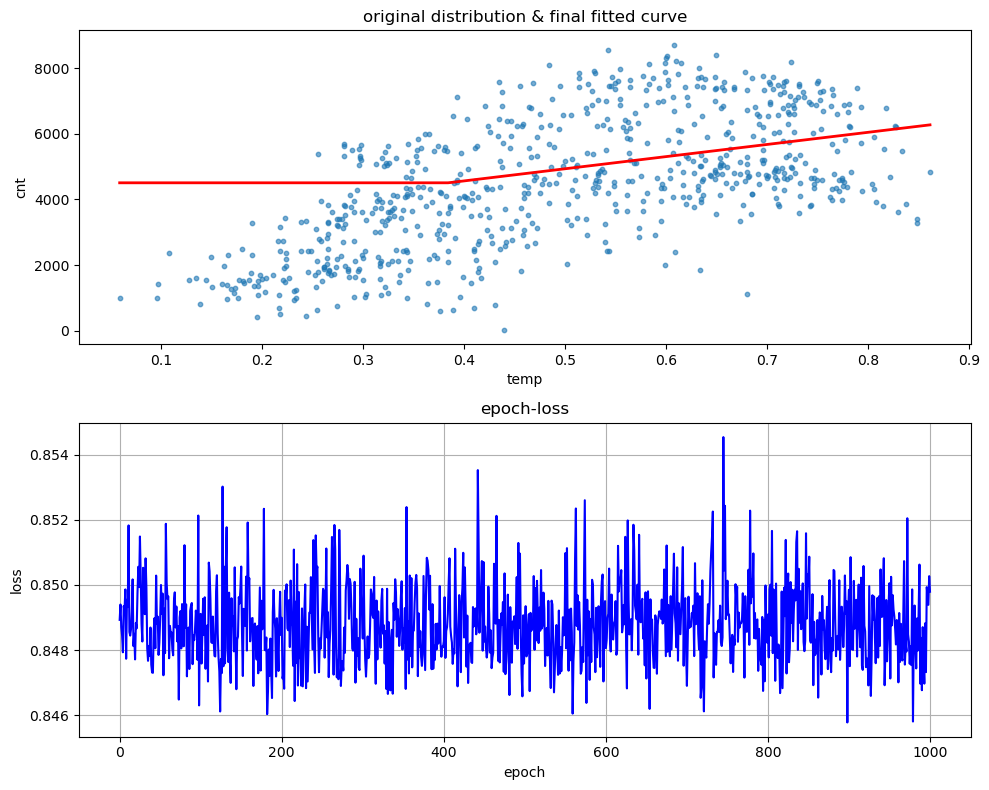

In [60]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X_sorted.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

这里我把负区域的斜率都调至0.7了都还是没有明显的变化，不知道是不是代码有问题。但可以肯定的是，这种改进不能根本上解决问题

***
## 写在最后
一开始，我以为这个题就是一个非常简单的线性回归问题，但在做题的过程中，我才发现这个题非常的有趣。在做这个题的过程中，加深了我对线性模型和激活函数的理解，也让我在发现问题，分析问题，解决问题的过程中感到了快乐。